# Single-cell Scanpy analysis — H068 PBMC

This notebook performs comprehensive analysis of single-cell RNA-seq data from 
peripheral blood mononuclear cells (PBMC) using the Scanpy toolkit. The pipeline
includes quality control, normalization, clustering, and cell type annotation.

In [23]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread

print("Libraries for single-cell analysis imported successfully")

Libraries for single-cell analysis imported successfully


In [29]:
# set plotting defaults
sc.settings.set_figure_params(dpi=100) # Настройка параметров визуализации Scanpy для единообразных графиков
plt.rcParams['figure.figsize'] = (6,4) # Установка стандартного размера графиков для matplotlib

# data directory 
data_dir = '/home/kslepov/single-cell-analysis/H068_sample_filtered_feature_bc_matrix'
barcodes_file = os.path.join(data_dir, 'barcodes.tsv.gz')
features_file = os.path.join(data_dir, 'features.tsv.gz')
matrix_file = os.path.join(data_dir, 'matrix.mtx.gz')

print('Paths:')
print(barcodes_file)
print(features_file)
print(matrix_file)

Paths:
/home/kslepov/single-cell-analysis/H068_sample_filtered_feature_bc_matrix/barcodes.tsv.gz
/home/kslepov/single-cell-analysis/H068_sample_filtered_feature_bc_matrix/features.tsv.gz
/home/kslepov/single-cell-analysis/H068_sample_filtered_feature_bc_matrix/matrix.mtx.gz


In [32]:
# Read barcodes and features

# Чтение файла баркодов - идентификаторов клеток, прошедших фильтрацию CellRanger
barcodes = pd.read_csv(barcodes_file, sep='\t', header=None, compression='gzip')
# Чтение файла фич - аннотаций генов (ID, символы, типы)
features = pd.read_csv(features_file, sep='\t', header=None, compression='gzip')

print('Barcodes shape:', barcodes.shape)
print('Features shape:', features.shape)

# Read mtx using scipy.io.mmread (чтение основной матрицы экспрессии в формате MatrixMarket)
try:
    X = mmread(matrix_file)
    # ЯВНОЕ ПРЕОБРАЗОВАНИЕ В CSR
    X = sp.csr_matrix(X)
    print('Matrix read successfully, converted to CSR')
except Exception as e:
    print('mmread failed:', e)
    # fallback
    X = pd.read_csv(matrix_file, sep=' ', header=None, compression='gzip', skiprows=2)
    X = sp.csr_matrix((X[2].values, (X[0]-1, X[1]-1)), shape=(int(X[0].max()), int(X[1].max())))

print('Matrix shape (raw):', X.shape)
print('Matrix format:', X.format)  # Должно быть 'csr'

# 10X mtx is (genes x barcodes) -> transpose to cells x genes
adata = ad.AnnData(X=X.T.tocsr()) # Транспонируем и преобразуем в CSR

# add obs/var names
adata.obs_names = barcodes[0].astype(str).values # Добавление имен наблюдений (клеток) из баркодов

# features: col0 - gene id, col1 - gene symbol, col2 - feature type
adata.var['gene_id'] = features[0].astype(str).values
adata.var['gene_symbols'] = features[1].astype(str).values
adata.var['feature_types'] = features[2].astype(str).values

# set var_names to gene symbols, but keep unique names
adata.var_names = adata.var['gene_symbols'].values
adata.var_names_make_unique() # Добавляет суффиксы к дублирующимся именам генов

print('\nAnnData summary:')
print(adata)

Barcodes shape: (9234, 1)
Features shape: (36640, 3)
Matrix read successfully, converted to CSR
Matrix shape (raw): (36640, 9234)
Matrix format: csr

AnnData summary:
AnnData object with n_obs × n_vars = 9234 × 36640
    var: 'gene_id', 'gene_symbols', 'feature_types'


### Question 1 

В .mtx файле содержится информация о 9,234 клетках и 36,640 генах. CellRanger автоматически отбирает только качественные клетки, отсеивая пустые капли (которые не содержат клеток) и повреждённые клетки с аномально высоким содержанием митохондриальных генов — это признаки погибающих клеток.

The .mtx file contains information about 9,234 cells and 36,640 genes. CellRanger automatically selects only high-quality cells by filtering out empty droplets (which don't contain cells) and damaged cells with abnormally high mitochondrial gene content — indicators of dying cells.

In [34]:
# CreateSeurat-like filtering (min.cells=3, min.features=200) analog in Scanpy
# In Scanpy terms: filter genes present in at least 3 cells, and cells with at least 200 genes

# Сохраняем исходные количества для сравнения после фильтрации
n_cells_before = adata.n_obs
n_genes_before = adata.n_vars

# Фильтрация генов: оставляем только гены, экспрессированные хотя бы в 3 клетках
# Это убирает редкие гены, которые могут быть шумом или артефактами секвенирования
sc.pp.filter_genes(adata, min_cells=3)

# Фильтрация клеток: оставляем только клетки с минимум 200 обнаруженными генами
# Клетки с меньшим количеством генов считаются пустыми каплями или низкокачественными
sc.pp.filter_cells(adata, min_genes=200)

print(f'Genes before: {n_genes_before}, after filter_genes(min_cells=3): {adata.n_vars}')
print(f'Cells before: {n_cells_before}, after filter_cells(min_genes=200): {adata.n_obs}')

# Сохраняем результаты фильтрации для отчёта
# uns['report'] - специальное место в AnnData для хранения мета-информации анализа
adata.uns['report'] = {}
adata.uns['report']['n_genes_after_min_cells3'] = int(adata.n_vars)
adata.uns['report']['n_cells_after_min_features200'] = int(adata.n_obs)

print('\nFiltering finished')

Genes before: 22638, after filter_genes(min_cells=3): 22622
Cells before: 8660, after filter_cells(min_genes=200): 8660

Filtering finished


### Question 2

При фильтрации с параметрами min.cells=3 и min.features=200 отбираются только гены, экспрессированные как минимум в 3 клетках, и клетки, содержащие как минимум 200 генов. После первичной фильтрации осталось 8,660 клеток (из исходных 9,234) и 22,638 генов (из исходных 36,640).

Примечание: при повторном выполнении фильтрации на уже отфильтрованных данных результаты меняются, так как фильтры применяются к уже уменьшенному набору данных.

With filtering parameters min.cells=3 and min.features=200, we select only genes expressed in at least 3 cells, and cells containing at least 200 genes. After initial filtering, 8,660 cells remain (from original 9,234) and 22,638 genes (from original 36,640).

Note: Re-running filtration on already filtered data changes the results, as filters are applied to the already reduced dataset.

Basic QC metrics added to adata.obs:
['n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo']


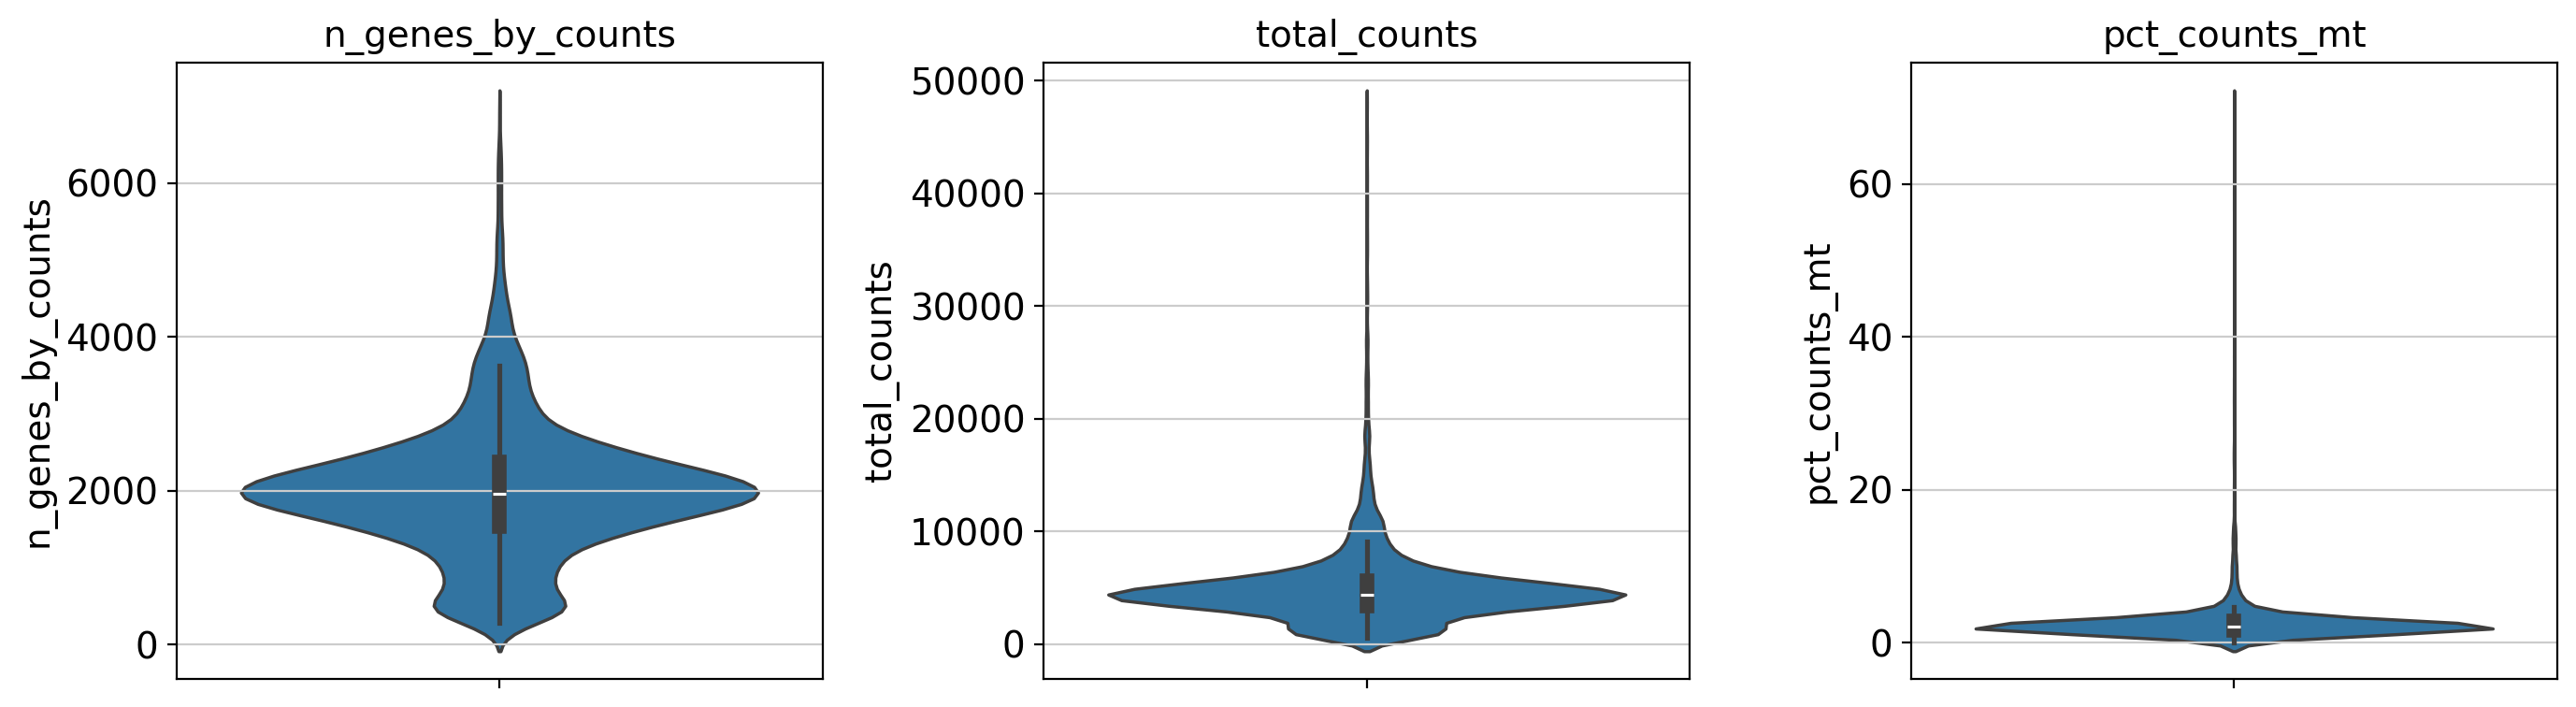

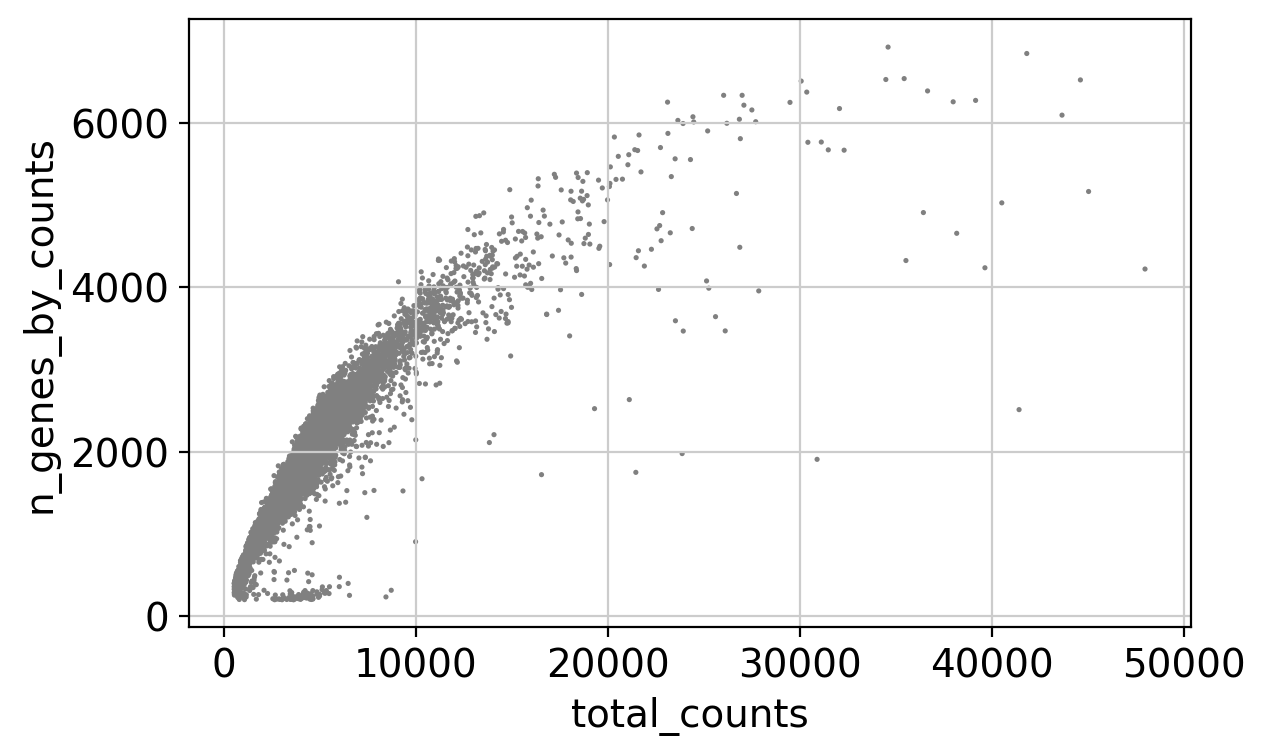

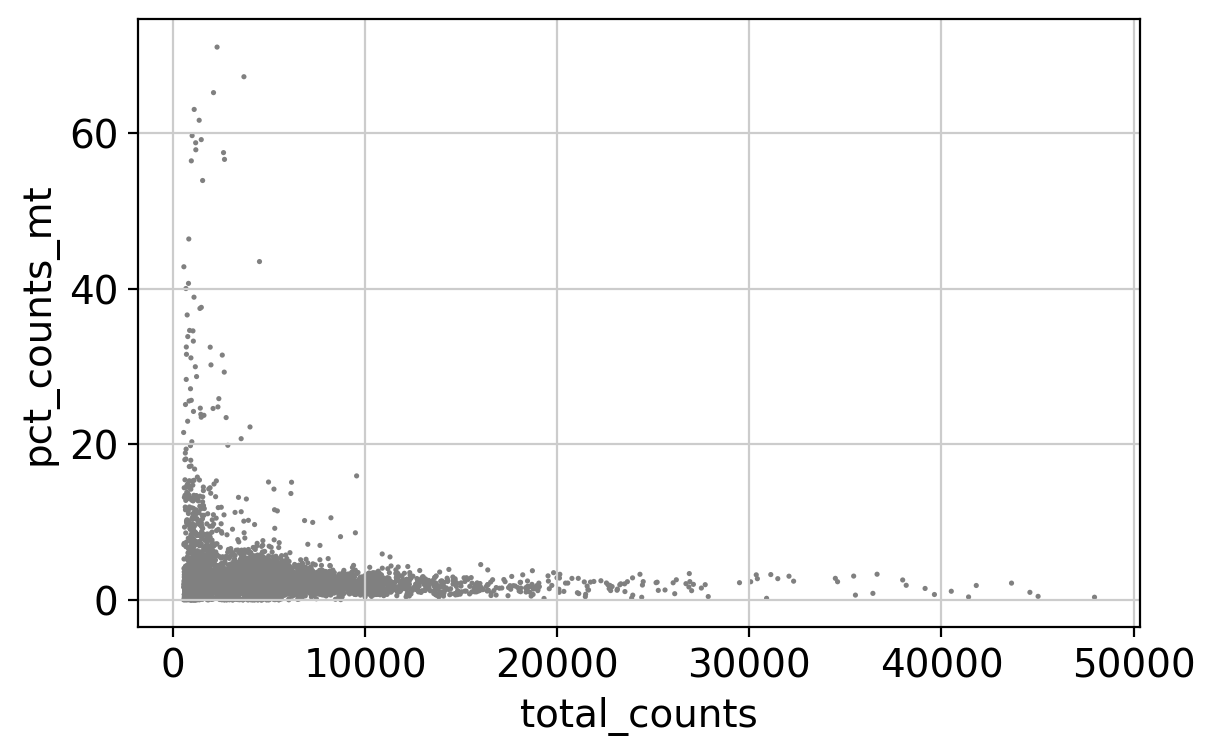

Cells before QC subset: 8660, after subset: 6452


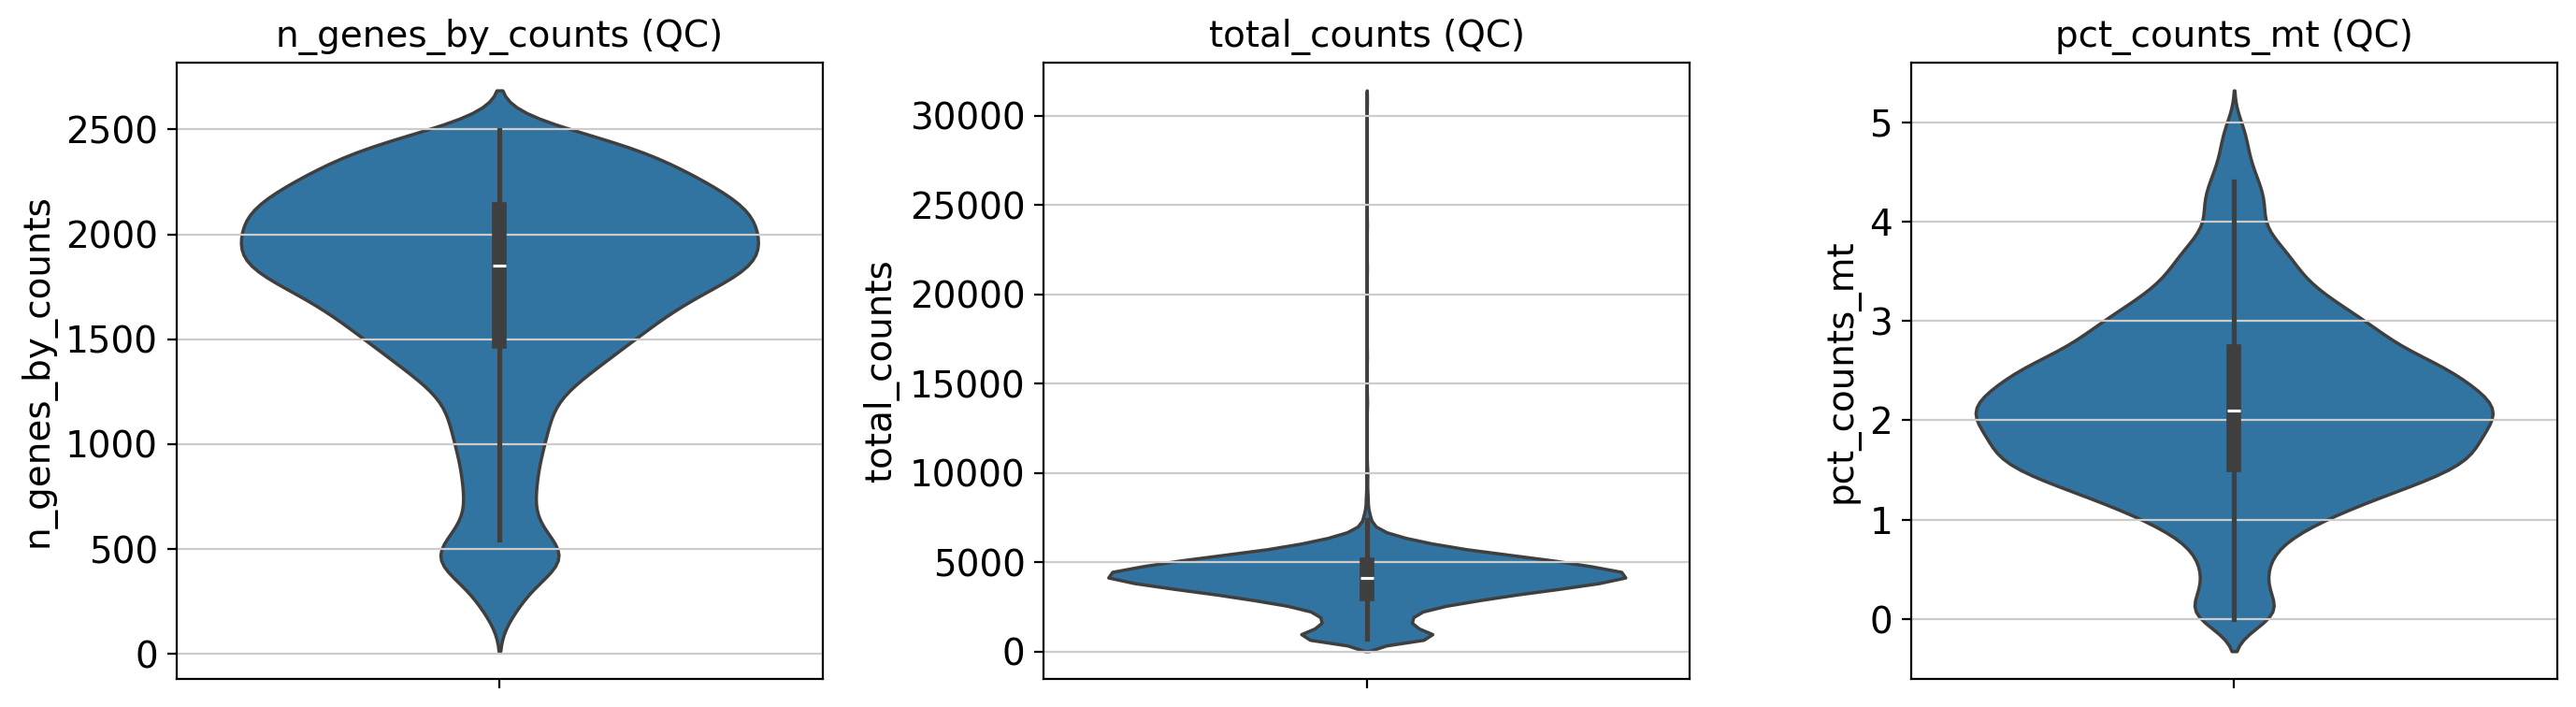

In [36]:
# QC metrics (compute n_genes, total_counts, pct_counts_mt) and apply example thresholds

# Помечаем митохондриальные гены (у человека начинаются с 'MT-')
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
# Помечаем рибосомальные гены (начинаются с 'RPS', 'RPL')
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))

# Вычисляем QC метрики и добавляем их в adata.obs
# qc_vars указывает для каких генов считать процентную долю
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], inplace=True)

print('Basic QC metrics added to adata.obs:')
print(adata.obs.columns.tolist())

# Visualize distributions similar to Seurat VlnPlot
fig, axes = plt.subplots(1,3, figsize=(14,4))

sns.violinplot(y=adata.obs['n_genes_by_counts'], ax=axes[0]) # n_genes_by_counts - количество обнаруженных генов на клетку
axes[0].set_title('n_genes_by_counts')

sns.violinplot(y=adata.obs['total_counts'], ax=axes[1]) # total_counts - общее количество молекул (UMI) на клетку 
axes[1].set_title('total_counts')

sns.violinplot(y=adata.obs['pct_counts_mt'], ax=axes[2]) # pct_counts_mt - процент митохондриальных транскриптов
axes[2].set_title('pct_counts_mt')

plt.tight_layout()
plt.show()

# scatter plots like FeatureScatter

# Показывает взаимосвязь между количеством UMI и количеством генов
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
# Показывает взаимосвязь между количеством UMI и процентом митохондриальных генов
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

# Suggested thresholds example
min_genes = 200      # Минимальное количество генов (уже применено ранее)
max_genes = 2500     # Максимальное количество генов - убирает дублеты и артефакты
max_mt = 5.0         # Максимальный процент митохондриальных генов

# Подсчет клеток до фильтрации
n_before = adata.n_obs

# Фильтрация клеток по заданным порогам:
# - Клетки с 200-2500 генами (избегаем пустых капель и дублетов)
# - Клетки с <5% митохондриальных генов (избегаем поврежденных клеток)
adata_qc = adata[(adata.obs['n_genes_by_counts'] > min_genes) &
                 (adata.obs['n_genes_by_counts'] < max_genes) &
                 (adata.obs['pct_counts_mt'] < max_mt)].copy()

print(f'Cells before QC subset: {n_before}, after subset: {adata_qc.n_obs}')

# Сохраняем результат фильтрации для отчета
adata_qc.uns['report'] = dict()
adata_qc.uns['report']['n_cells_after_qc_subset'] = int(adata_qc.n_obs)

# Show Violin plots for the filtered object
# Показывает улучшение качества данных после удаления выбросов
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.violinplot(y=adata_qc.obs['n_genes_by_counts'], ax=axes[0])
axes[0].set_title('n_genes_by_counts (QC)')
sns.violinplot(y=adata_qc.obs['total_counts'], ax=axes[1])
axes[1].set_title('total_counts (QC)')
sns.violinplot(y=adata_qc.obs['pct_counts_mt'], ax=axes[2])
axes[2].set_title('pct_counts_mt (QC)')
plt.tight_layout(); plt.show()

### Question 3

Были построены violin plots для метрик качества: количества генов на клетку (n_genes_by_counts), общего количества UMI (total_counts) и процента митохондриальных генов (pct_counts_mt). Рекомендованы пороги фильтрации: клетки с 200-2500 генами и <5% митохондриальных генов. Такая фильтрация удаляет:

Клетки с малым количеством генов (<200) — пустые капли/низкокачественные клетки  
Клетки с аномально высоким количеством генов (>2500) — возможные дублеты  
Клетки с высоким процентом митохондриальных генов (≥5%) — поврежденные/умирающие клетки  
После фильтрации осталось 6,452 клетки (из исходных 8,660).  

Violin plots were created for quality metrics: genes per cell (n_genes_by_counts), total UMI counts (total_counts), and mitochondrial percentage (pct_counts_mt). Recommended filtration thresholds: cells with 200-2500 genes and <5% mitochondrial genes. This filtering removes:

Cells with low gene counts (<200) — empty droplets/low-quality cells  
Cells with abnormally high gene counts (>2500) — potential doublets  
Cells with high mitochondrial percentage (≥5%) — damaged/dying cells  
After filtration, 6,452 cells remain (from original 8,660).  

In [9]:
!pip install scikit-misc

In [37]:
# Highly variable genes (HVGs) and top 5

# Нормализация данных: приводим общую экспрессию в каждой клетке к 10,000 counts
# Это позволяет сравнивать клетки с разной общей глубиной секвенирования
sc.pp.normalize_total(adata_qc, target_sum=1e4)
# Log-трансформация: преобразование log(1 + x) для стабилизации дисперсии
# Делает данные более нормально распределенными и улучшает последующий анализ
sc.pp.log1p(adata_qc)
# Идентификация высоковариабельных генов (HVGs) - ключевой шаг для уменьшения размерности
# n_top_genes=2000 - выбираем 2000 самых вариабельных генов для последующего анализа
sc.pp.highly_variable_genes(adata_qc, n_top_genes=2000, flavor='seurat')

# Создаем DataFrame с высоковариабельными генами для дальнейшего анализа
hvg = adata_qc.var[adata_qc.var['highly_variable']].copy()

# Сортируем гены по дисперсии (dispersions) и выводим топ-10
print('Number of HVGs found:', hvg.shape[0])
print('Top 10 HVGs:')
print(hvg.sort_values('dispersions', ascending=False).head(10).index.tolist())
print('\nTop 5 HVGs:')
print(hvg.sort_values('dispersions', ascending=False).head(5).index.tolist())

# Сохраняем топ-5 HVG в отчет для дальнейшего использования
adata_qc.uns['report']['top5_hvgs'] = hvg.sort_values('dispersions', ascending=False).head(5).index.tolist()

Number of HVGs found: 2000
Top 10 HVGs:
['Hu.CD57', 'Hu.CD16', 'Hu.TCR.GD', 'Hu.TCR.Va24Ja18', 'Hu.CD183', 'Hu.CCR10', 'Hu.CD294', 'Hu.HLA.DR', 'IGHA1', 'Hu.CD127']

Top 5 HVGs:
['Hu.CD57', 'Hu.CD16', 'Hu.TCR.GD', 'Hu.TCR.Va24Ja18', 'Hu.CD183']


### Question 4

Пять самых вариабельных генов: Hu.CD57, Hu.CD16, Hu.TCR.GD, Hu.TCR.Va24Ja18, Hu.CD183. Интересно, что все топ-5 генов — это поверхностные маркеры иммунных клеток (CD маркеры и TCR), что характерно для данных PBMC и отражает разнообразие иммунных популяций в образце.

The five most variable genes are: Hu.CD57, Hu.CD16, Hu.TCR.GD, Hu.TCR.Va24Ja18, Hu.CD183. Notably, all top-5 genes are immune cell surface markers (CD markers and TCR), which is typical for PBMC data and reflects the diversity of immune populations in the sample.

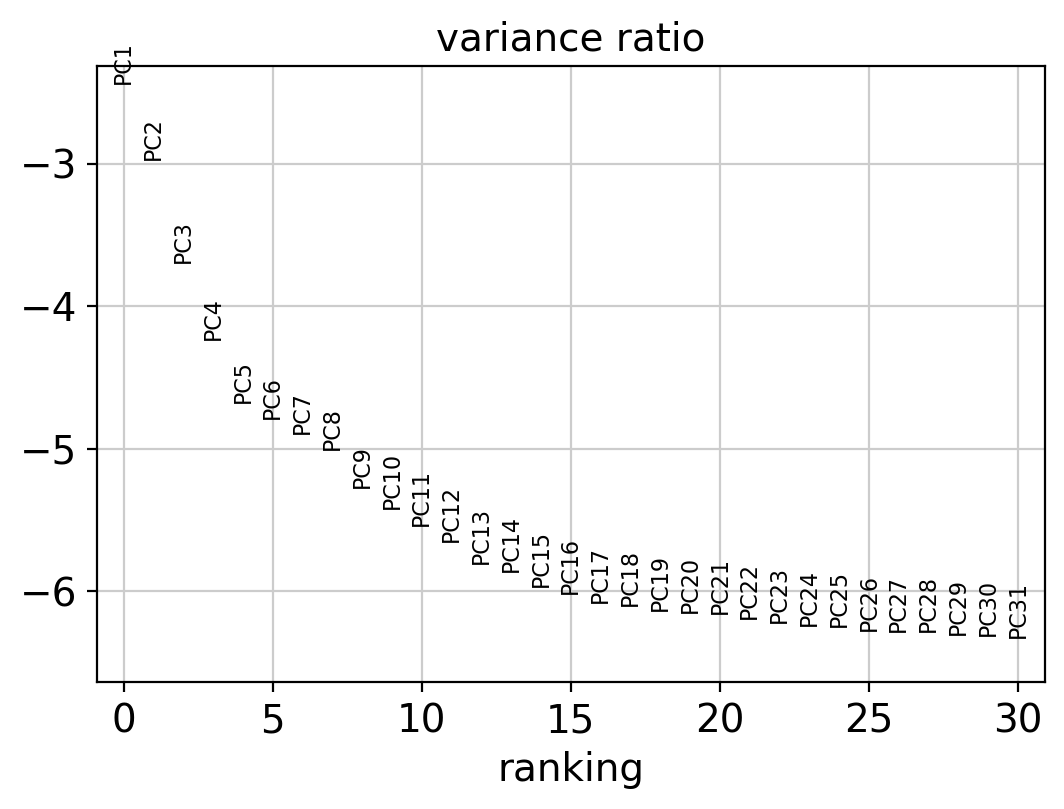

Explained variance ratio (first 20 PCs):
[0.08720633 0.05124919 0.02490266 0.01445388 0.00933202 0.00829191
 0.00746809 0.00671149 0.00510695 0.00441069 0.00392912 0.00351663
 0.00301413 0.00283976 0.00256278 0.00243699 0.00229368 0.00224523
 0.00215964 0.0021373 ]


In [42]:
# PCA and Elbow plot

# Масштабирование данных: центрирование и приведение дисперсии к 1
# max_value=10 - обрезает экстремальные значения для стабильности анализа
sc.pp.scale(adata_qc, max_value=10)

# Выполнение PCA (Principal Component Analysis) - уменьшение размерности
# svd_solver='arpack' - эффективный алгоритм для больших разреженных матриц
sc.tl.pca(adata_qc, svd_solver='arpack')

# variance ratio plot (ElbowPlot analogue)
# log=True - логарифмическая шкала для лучшей визуализации "локтя"
# График показывает, какая доля дисперсии объясняется каждой компонентой
sc.pl.pca_variance_ratio(adata_qc, log=True)

# print explained variance for first 20 PCs
print('Explained variance ratio (first 20 PCs):')
print(adata_qc.uns['pca']['variance_ratio'][:20])

### Question 5

Анализ графика объясненной дисперсии показывает, что оптимально использовать 15-20 главных компонент. Первые компоненты несут основную биологическую информацию: например, PC1 (8.7%) отражает различия между основными типами клеток, а PC2 (5.1%) — более тонкие различия внутри популяций. После 15-й компоненты каждая последующая добавляет менее 0.3% дисперсии, что скорее соответствует техническому шуму, чем биологически значимым сигналам.

The variance analysis suggests using 15-20 principal components provides the best balance. The early components capture major biological signals: PC1 (8.7%) likely separates major cell types, while PC2 (5.1%) captures finer distinctions within populations. Beyond component 15, each additional PC contributes less than 0.3% variance, representing mostly technical noise rather than meaningful biological variation.

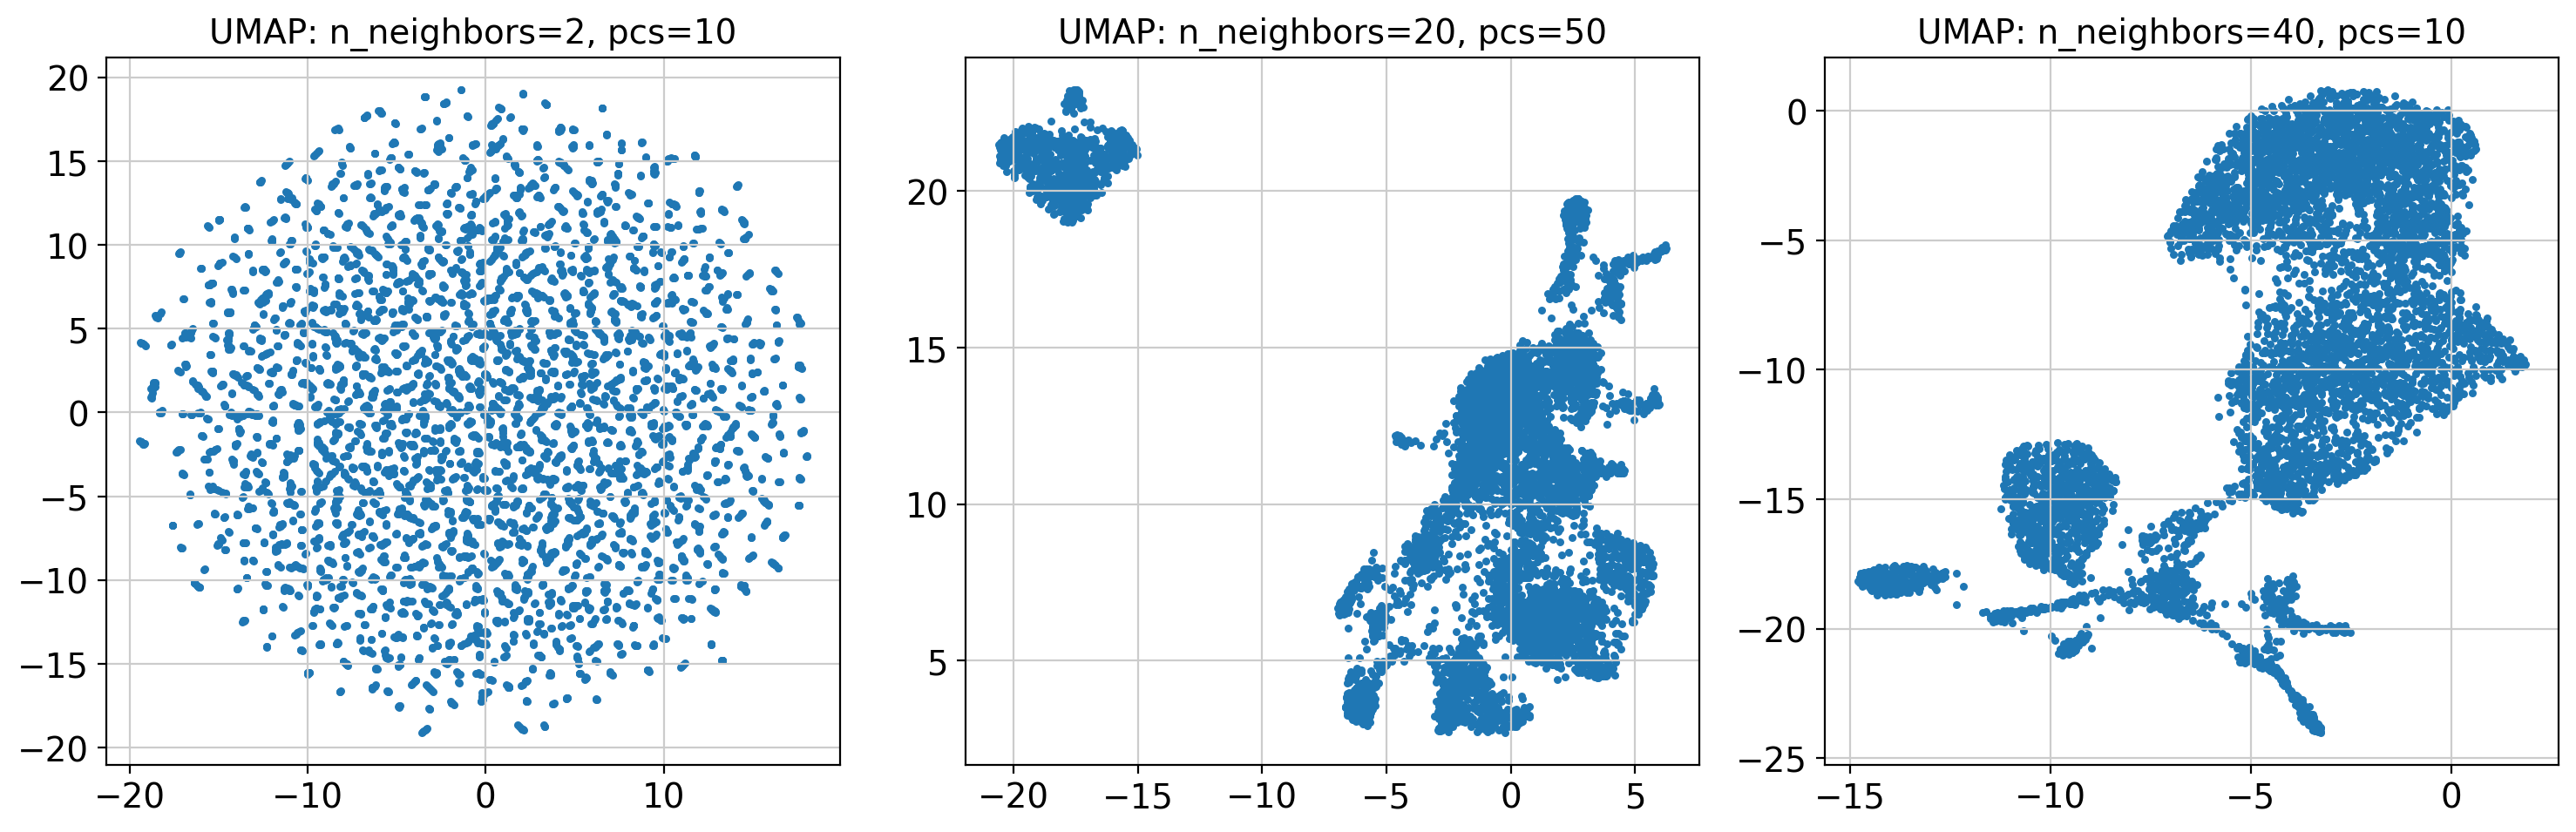

In [44]:
# UMAP variants
# Variant 1: very small neighbors (use 10 PCs)
# n_neighbors=2 - очень локальная структура, показывает мелкие кластеры и выбросы
# n_pcs=10 - использует только основные компоненты, игнорируя шумовые
sc.pp.neighbors(adata_qc, n_neighbors=2, n_pcs=10)
sc.tl.umap(adata_qc)
# Сохраняем результат в отдельный слот для сравнения
adata_qc.obsm['X_umap_n2_p10'] = adata_qc.obsm['X_umap'].copy()

# Variant 2: more neighbors and many PCs
# n_neighbors=20 - баланс между локальной и глобальной структурой
# n_pcs=50 - использует почти все компоненты, включая потенциально шумовые
sc.pp.neighbors(adata_qc, n_neighbors=20, n_pcs=50)
sc.tl.umap(adata_qc)
adata_qc.obsm['X_umap_n20_p50'] = adata_qc.obsm['X_umap'].copy()

# Variant 3: classic-like
# n_neighbors=40 - акцент на глобальную структуру, большие кластеры
# n_pcs=10 - только информативные компоненты, минимум шума
sc.pp.neighbors(adata_qc, n_neighbors=40, n_pcs=10)
sc.tl.umap(adata_qc)
adata_qc.obsm['X_umap_n40_p10'] = adata_qc.obsm['X_umap'].copy()

# Plot the three variants side-by-side
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].scatter(adata_qc.obsm['X_umap_n2_p10'][:,0], adata_qc.obsm['X_umap_n2_p10'][:,1], s=5)
axes[0].set_title('UMAP: n_neighbors=2, pcs=10')
axes[1].scatter(adata_qc.obsm['X_umap_n20_p50'][:,0], adata_qc.obsm['X_umap_n20_p50'][:,1], s=5)
axes[1].set_title('UMAP: n_neighbors=20, pcs=50')
axes[2].scatter(adata_qc.obsm['X_umap_n40_p10'][:,0], adata_qc.obsm['X_umap_n40_p10'][:,1], s=5)
axes[2].set_title('UMAP: n_neighbors=40, pcs=10')
plt.tight_layout(); plt.show()

### Question 6

Меньшее число соседей (n_neighbors=2) лучше выявляет тонкую структуру данных и мелкие субпопуляции, но может создавать артефактные кластеры и чувствительно к шуму. Большее число соседей (n_neighbors=40) дает стабильные крупные кластеры и устойчивость к шуму, но приводит к потере тонкой структуры и объединению близких субпопуляций.

Меньшее число главных компонент (n_pcs=10) уменьшает влияние технического шума и фокусируется на основных биологических сигналах, но может терять информативные вариации. Большее число компонент (n_pcs=50) сохраняет больше биологической вариации, но включает технический шум и может вызывать перекластеризацию.


Fewer neighbors (n_neighbors=2) better reveals fine data structure and small subpopulations, but may create artifactual clusters and is sensitive to noise. More neighbors (n_neighbors=40) provides stable large clusters and noise resistance, but leads to loss of fine structure and merging of close subpopulations.

Fewer principal components (n_pcs=10) reduces technical noise impact and focuses on major biological signals, but may lose informative variations. More components (n_pcs=50) preserves more biological variation, but includes technical noise and may cause over-clustering.

In [16]:
!pip3 install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 1.6 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: igraph
    Found existing installation: igraph 0.11.9
    Uninstalling igraph-0.11.9:
      Successfully uninstalled igraph-0.11.9


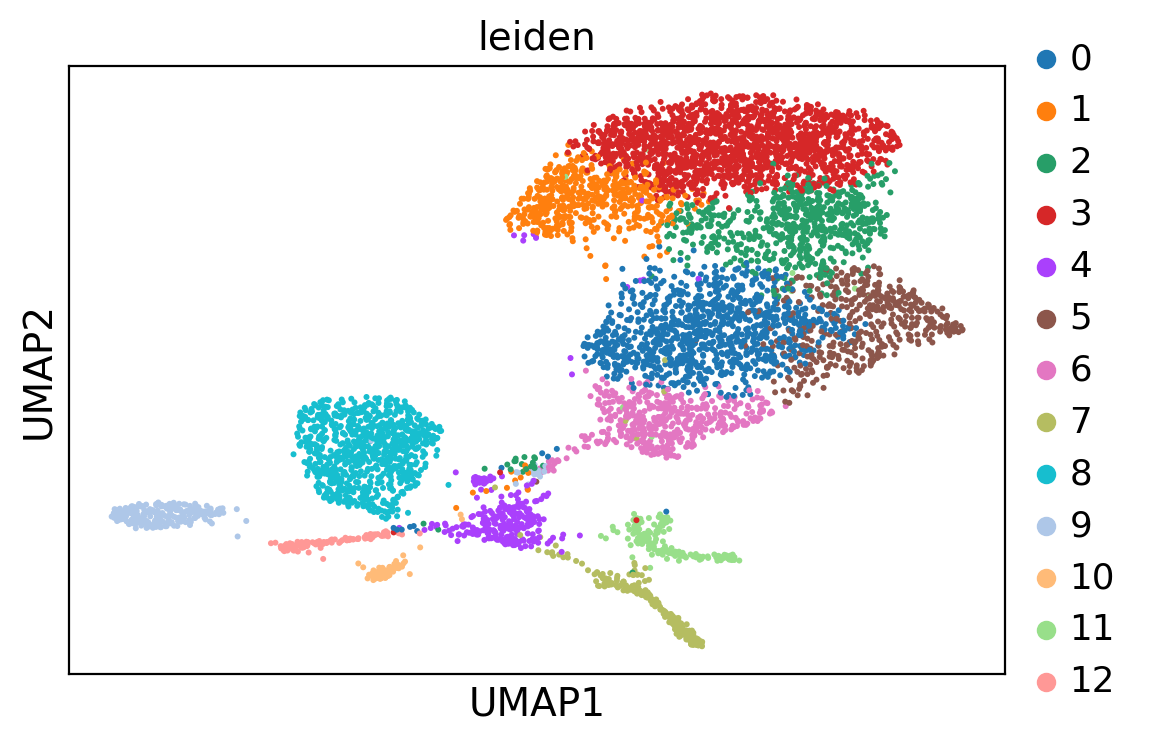

/home/kslepov/.conda/envs/python_main/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kslepov/.conda/envs/python_main/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kslepov/.conda/envs/python_main/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kslepov/.conda/envs/python_main/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kslepov/.conda/envs/python_main/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2

Cluster 0 top 5 markers:
['NKG7', 'CCL5', 'CST7', 'HLA-C', 'CTSW']
Cluster 1 top 5 markers:
['Hu.CD27', 'LEF1', 'Hu.CD62L', 'RPL32', 'RPL34']
Cluster 2 top 5 markers:
['ZFP36L2', 'IL32', 'TMSB4X', 'JUNB', 'SLC2A3']
Cluster 3 top 5 markers:
['RPL32', 'RPL13', 'RPS13', 'RPL30', 'LEF1']
Cluster 4 top 5 markers:
['Hu.CD183', 'Hu.CD127', 'Hu.CD69', 'Hu.TCR.GD', 'Hu.CD279']
Cluster 5 top 5 markers:
['DUSP2', 'ZFP36', 'NFKBIA', 'JUN', 'CD69']
Cluster 6 top 5 markers:
['GZMB', 'PRF1', 'CD247', 'GNLY', 'NKG7']
Cluster 7 top 5 markers:
['NRGN', 'PPBP', 'CAVIN2', 'HIST1H2AC', 'TUBB1']
Cluster 8 top 5 markers:
['CD74', 'HLA-DRA', 'HLA-DRB1', 'CD79A', 'HLA-DPA1']
Cluster 9 top 5 markers:
['DENND5A', 'KYNU', 'NEAT1', 'SOD2', 'ACSL1']
Cluster 10 top 5 markers:
['Hu.CD16', 'LIMK2', 'NAMPT', 'G0S2', 'SAT1']
Cluster 11 top 5 markers:
['HBA2', 'HBB', 'HBA1', 'SLC25A37', 'IFI27']
Cluster 12 top 5 markers:
['IFITM3', 'FTL', 'TYROBP', 'FTH1', 'CST3']


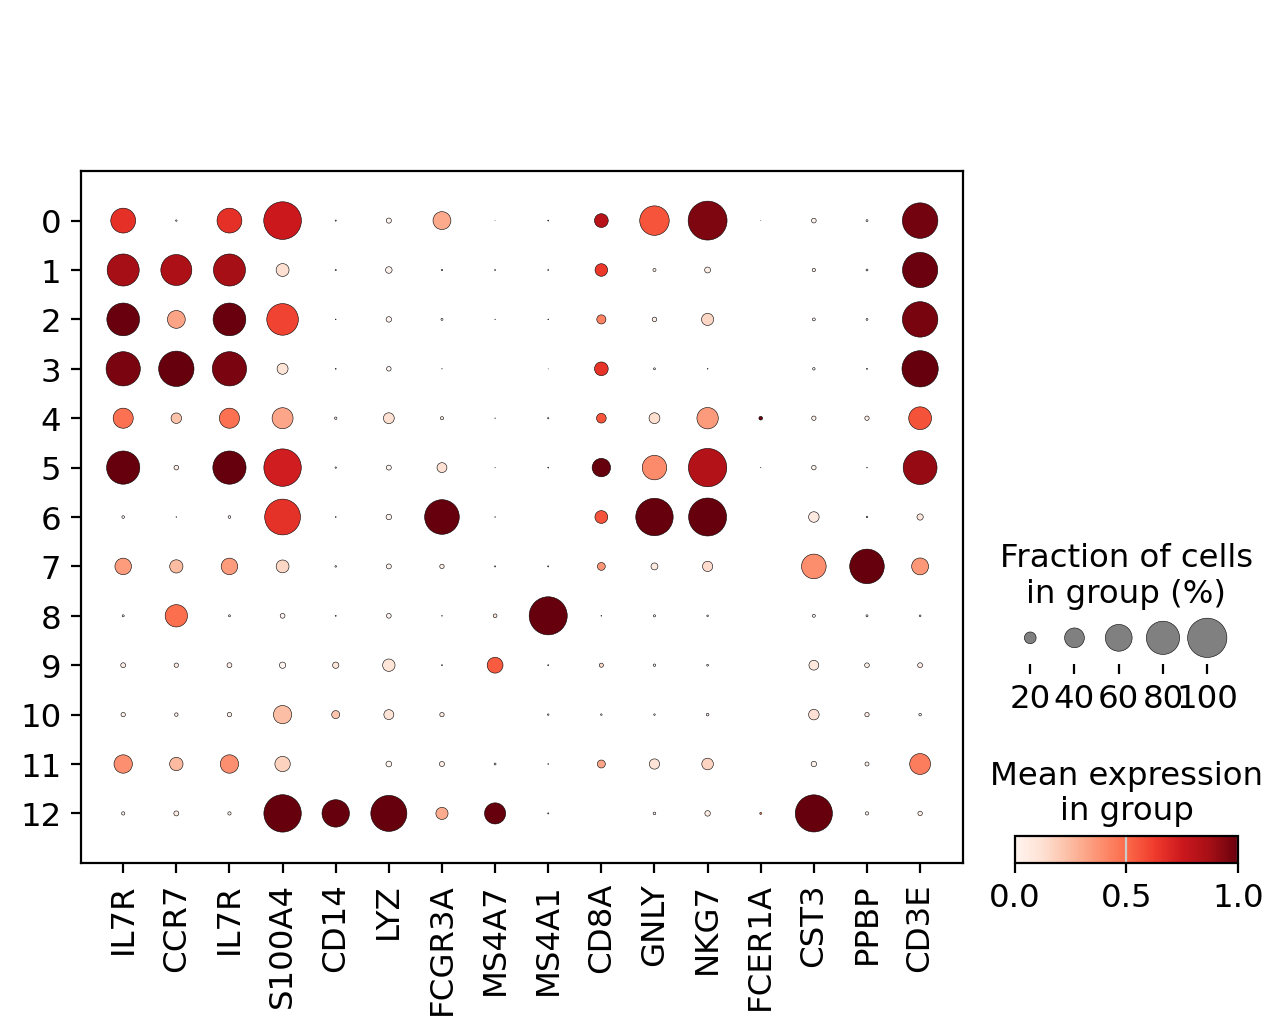

In [45]:
# Clustering (Leiden) and marker gene detection

# Use a standard neighbor setup for clustering
# n_neighbors=15 - баланс между локальной и глобальной структурой
# n_pcs=10 - используем первые 10 главных компонент для вычисления расстояний
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=10)

# Кластеризация алгоритмом Leiden с разрешением 0.5
# resolution=0.5 - среднее разрешение, создает умеренное количество кластеров
# flavor='igraph' - используем igraph вместо leidenalg для совместимости
# directed=False - неориентированный граф
# n_iterations=2 - количество итераций оптимизации
sc.tl.leiden(adata_qc, resolution=0.5, key_added='leiden', 
             flavor='igraph', directed=False, n_iterations=2)

# UMAP colored by leiden
# Показывает разделение клеток на кластеры в пространстве UMAP
sc.pl.umap(adata_qc, color='leiden')

# Rank genes for clusters
# method='wilcoxon' - используем критерий Вилкоксона для определения дифференциально экспрессированных генов
# Сравнивает экспрессию генов в целевом кластере против всех остальных кластеров
sc.tl.rank_genes_groups(adata_qc, 'leiden', method='wilcoxon')

# show top markers for each cluster (5 per cluster)
# Это помогает идентифицировать биологическую природу каждого кластера
for g in adata_qc.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_qc, group=g)
    print('Cluster', g, 'top 5 markers:')
    print(df['names'].head(5).tolist())

# Dotplot for canonical markers
marker_genes = {
    'Naive_CD4_T': ['IL7R','CCR7'],
    'Memory_CD4_T': ['IL7R','S100A4'],
    'CD14_Mono': ['CD14','LYZ'],
    'FCGR3A_Mono': ['FCGR3A','MS4A7'],
    'B_cells': ['MS4A1'],
    'CD8_T': ['CD8A'],
    'NK': ['GNLY','NKG7'],
    'DC': ['FCER1A','CST3'],
    'Platelet': ['PPBP'],
    'T_general': ['CD3E']
}

# Преобразование словаря в плоский список генов для dotplot
flat_markers = [g for gl in marker_genes.values() for g in gl]

# Построение dotplot для визуализации экспрессии маркерных генов по кластерам
# standard_scale='var' - масштабирование по генам для лучшего сравнения
sc.pl.dotplot(adata_qc, var_names=flat_markers, groupby='leiden', standard_scale='var')

# Save top markers to report
adata_qc.uns['report']['top_markers_per_cluster'] = {g: sc.get.rank_genes_groups_df(adata_qc, group=g)['names'].head(10).tolist()
                                                   for g in adata_qc.obs['leiden'].cat.categories}


### Question 7

На основе анализа маркерных генов можно аннотировать кластеры следующим образом:

Иммунные клетки:   
Кластер 0: NK-клетки (NKG7, CCL5, CST7)  
Кластер 1: Наивные T-клетки (CD27, LEF1, CD62L)  
Кластер 2: Активированные T-клетки (IL32, JUNB, SLC2A3)  
Кластер 4: Активированные T-клетки (CD183/CXCR3, CD127, CD69)  
Кластер 5: Активированные T-клетки (DUSP2, CD69, JUN)  
Кластер 6: Цитотоксические клетки (GZMB, PRF1, GNLY)  
Кластер 8: B-клетки (CD74, CD79A, HLA гены)

Миелоидные клетки:  
Кластер 9: Моноциты/макрофаги (DENND5A, KYNU, SOD2)    
Кластер 10: CD16+ моноциты (CD16, NAMPT)    
Кластер 12: Дендритные клетки/моноциты (IFITM3, TYROBP, CST3)  

Другие популяции:  
Кластер 7: Тромбоциты (NRGN, PPBP, TUBB1)  
Кластер 11: Эритроидные клетки (HBA2, HBB, HBA1)  
Кластер 3 требует дополнительного анализа (рибосомальные гены RPL/RPS).  


Based on marker gene analysis, the clusters can be annotated as follows:  

Immune cells:  
Cluster 0: NK cells (NKG7, CCL5, CST7)  
Cluster 1: Naive T cells (CD27, LEF1, CD62L)  
Cluster 2: Activated T cells (IL32, JUNB, SLC2A3)  
Cluster 4: Activated T cells (CD183/CXCR3, CD127, CD69)  
Cluster 5: Activated T cells (DUSP2, CD69, JUN)  
Cluster 6: Cytotoxic cells (GZMB, PRF1, GNLY)  
Cluster 8: B cells (CD74, CD79A, HLA genes) 

Myeloid cells:  
Cluster 9: Monocytes/macrophages (DENND5A, KYNU, SOD2)  
Cluster 10: CD16+ monocytes (CD16, NAMPT)  
Cluster 12: Dendritic cells/monocytes (IFITM3, TYROBP, CST3) 

Other populations:  
Cluster 7: Platelets (NRGN, PPBP, TUBB1)  
Cluster 11: Erythroid cells (HBA2, HBB, HBA1)  
Cluster 3 requires further analysis (ribosomal genes RPL/RPS).  

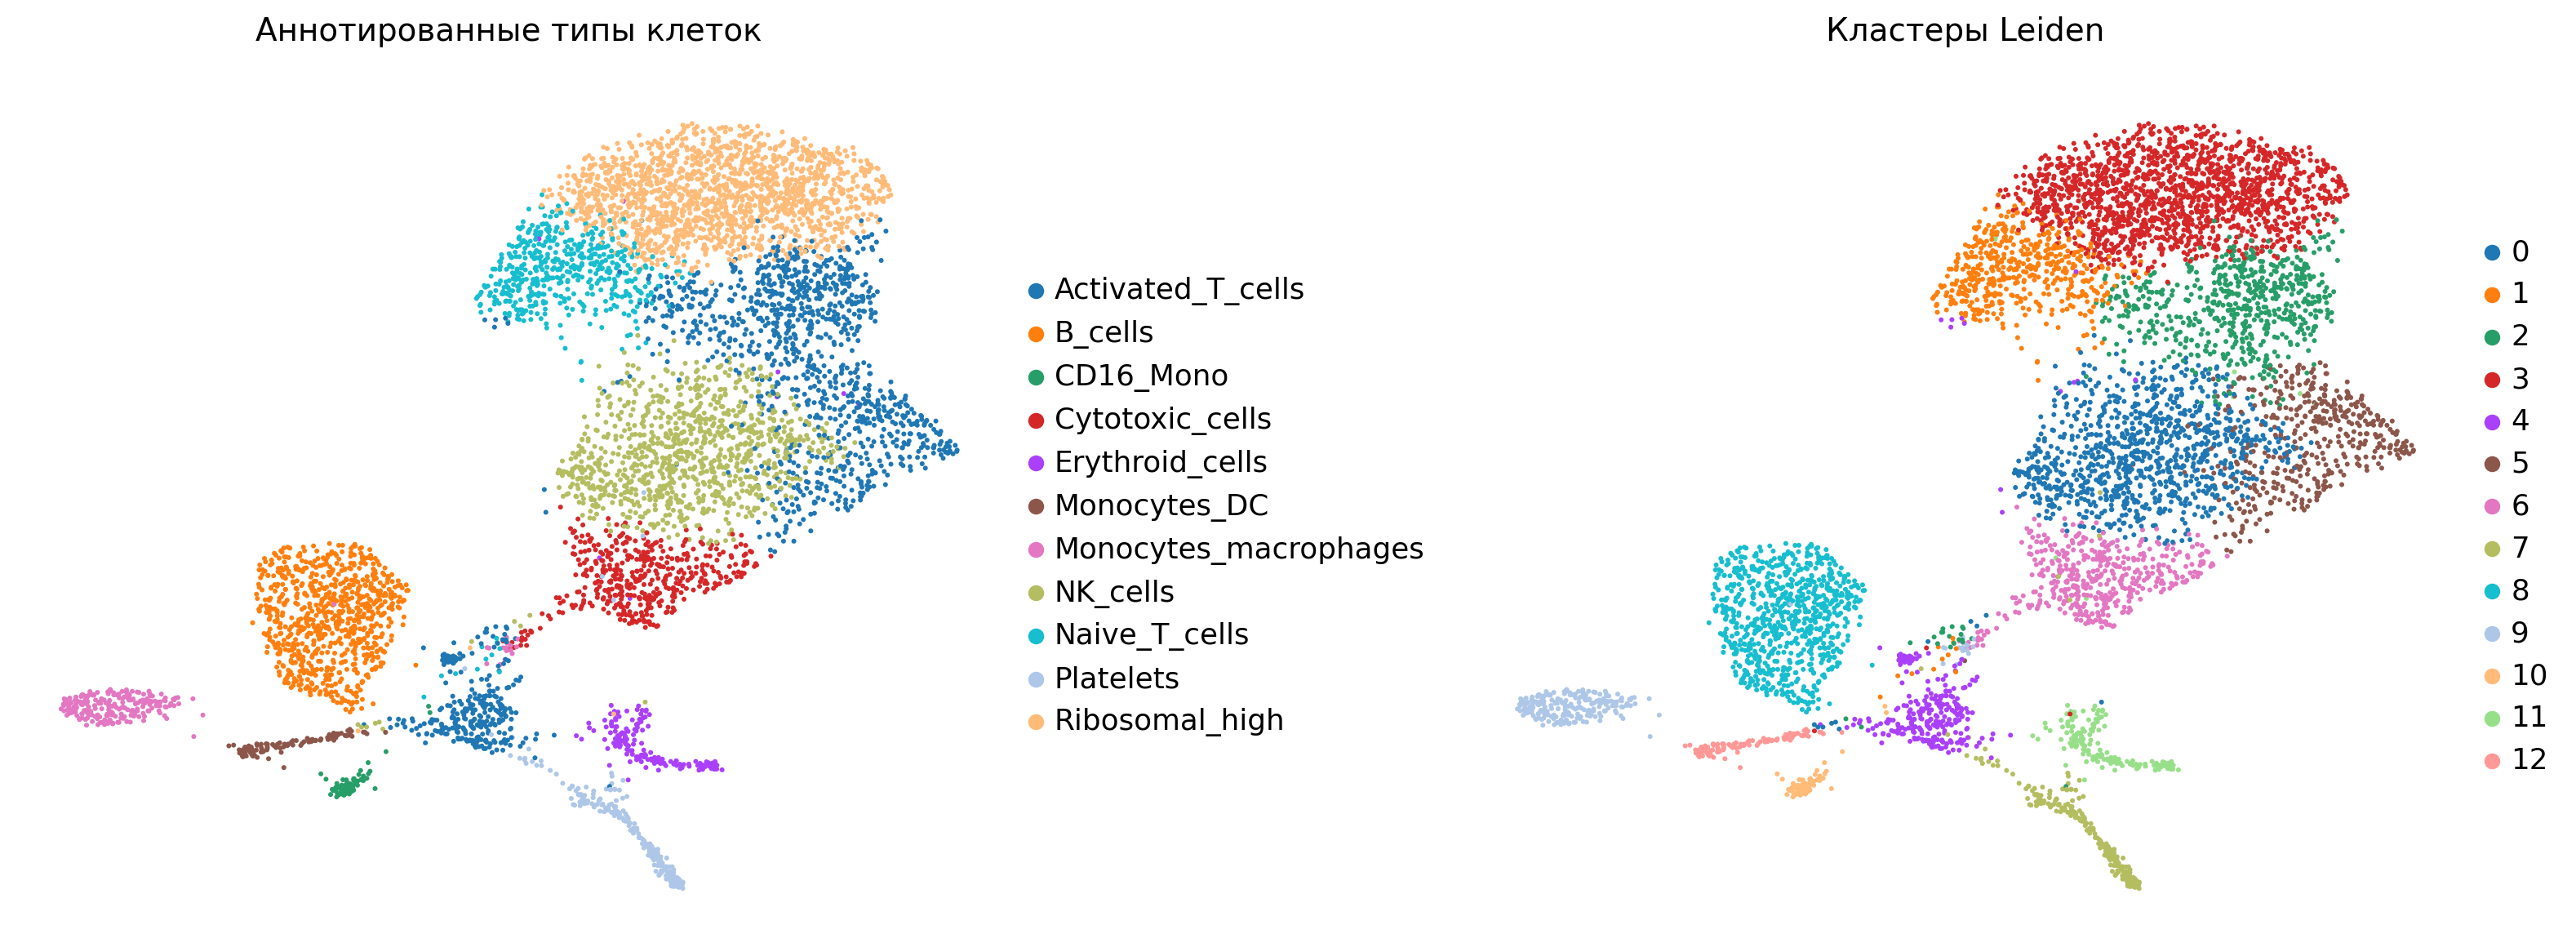


Отдельные графики для лучшей визуализации:


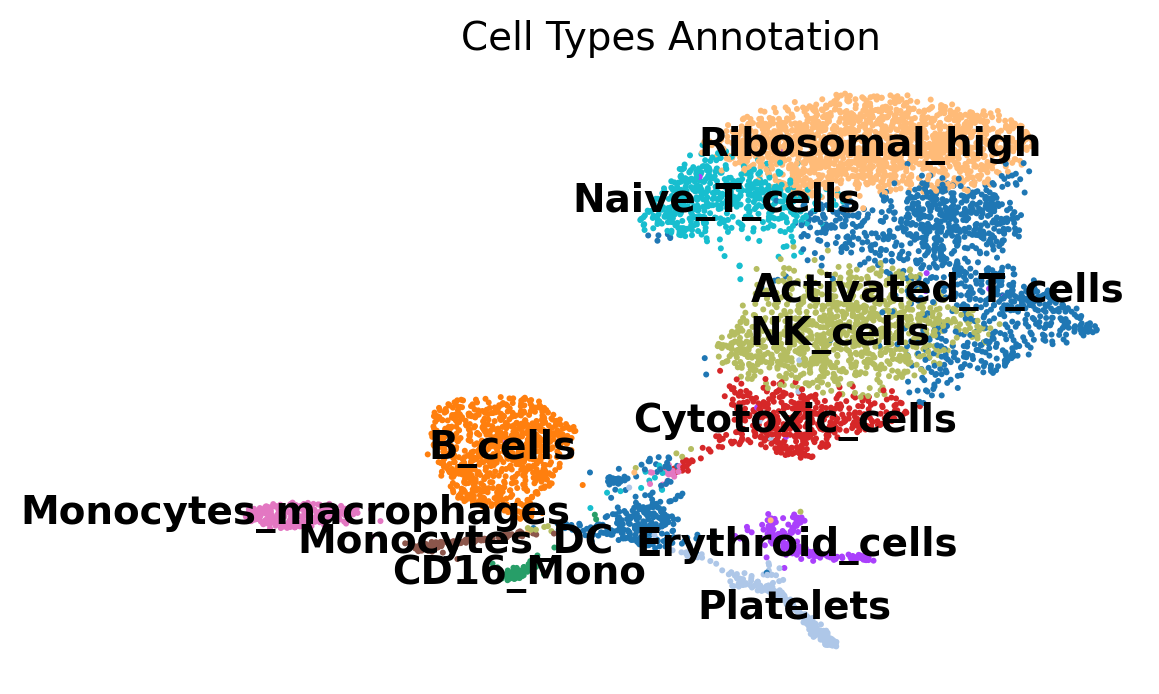

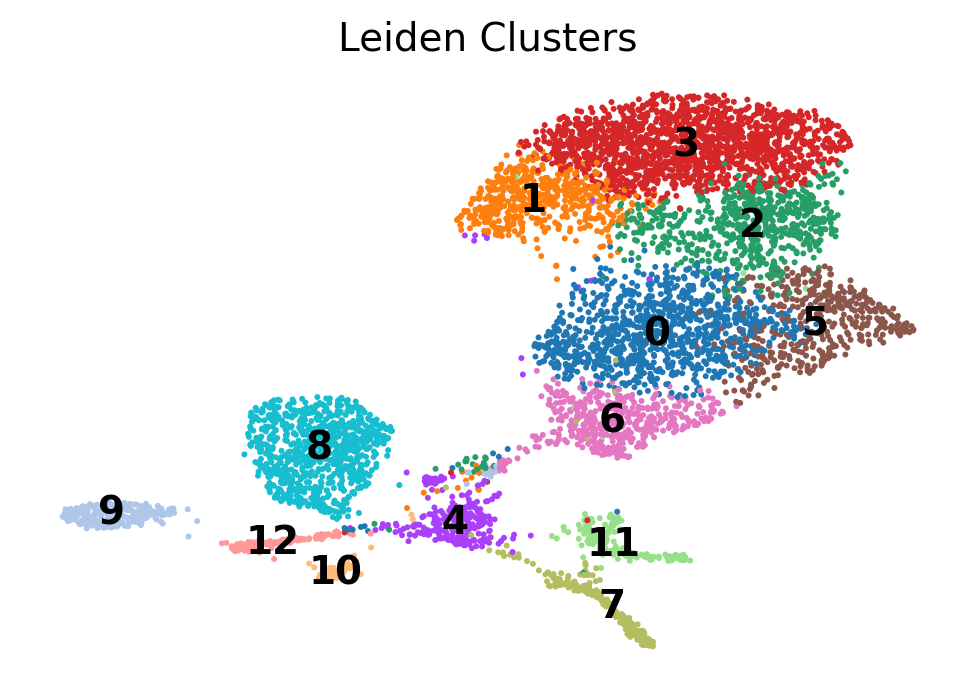

In [47]:
# Add cell type annotations
cell_type_annotations = {
    '0': 'NK_cells',           # NKG7, CCL5, CST7
    '1': 'Naive_T_cells',      # CD27, LEF1, CD62L  
    '2': 'Activated_T_cells',  # IL32, JUNB, SLC2A3
    '3': 'Ribosomal_high',     # RPL32, RPL13, RPS13 - требует проверки
    '4': 'Activated_T_cells',  # CD183, CD127, CD69
    '5': 'Activated_T_cells',  # DUSP2, CD69, JUN
    '6': 'Cytotoxic_cells',    # GZMB, PRF1, GNLY
    '7': 'Platelets',          # NRGN, PPBP, TUBB1
    '8': 'B_cells',            # CD74, CD79A, HLA-DRA
    '9': 'Monocytes_macrophages', # DENND5A, KYNU, SOD2
    '10': 'CD16_Mono',         # CD16, NAMPT
    '11': 'Erythroid_cells',   # HBA2, HBB, HBA1
    '12': 'Monocytes_DC'       # IFITM3, TYROBP, CST3
}

adata_qc.obs['cell_type'] = adata_qc.obs['leiden'].map(cell_type_annotations)

# Visualize with cell types - отдельные графики чтобы избежать наложения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Левый график: раскраска по типам клеток
sc.pl.umap(adata_qc, color='cell_type', ax=ax1, show=False, title='Cell Types', frameon=False)
ax1.set_title('Аннотированные типы клеток', fontsize=14, pad=20)

# Правый график: раскраска по кластерам Leiden
sc.pl.umap(adata_qc, color='leiden', ax=ax2, show=False, title='Leiden Clusters', frameon=False)
ax2.set_title('Кластеры Leiden', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# Дополнительно: отдельный график с легендой для лучшей читаемости
print("\nОтдельные графики для лучшей визуализации:")
sc.pl.umap(adata_qc, color='cell_type', title='Cell Types Annotation', 
           legend_loc='on data', frameon=False, show=True)

sc.pl.umap(adata_qc, color='leiden', title='Leiden Clusters', 
           legend_loc='on data', frameon=False, show=True)

# Update report
adata_qc.uns['report']['cell_type_annotations'] = cell_type_annotations

In [48]:
# Сохранение полного обработанного AnnData объекта в файл .h5ad
# Этот файл содержит все данные: нормализованную матрицу экспрессии, метаданные, PCA, UMAP, кластеры
out_h5ad = '/home/kslepov/single-cell-analysis/data/H068_scanpy_processed.h5ad'
adata_qc.write(out_h5ad)

# Создание и сохранение таблицы с присвоением кластеров для каждой клетки
# Формат: две колонки - barcode (идентификатор клетки) и cluster (номер кластера Leiden)
cluster_df = pd.DataFrame({
    'barcode': adata_qc.obs_names,           # Имена клеток (баркоды)
    'cluster': adata_qc.obs['leiden'].values # Номера кластеров
})
out_clusters = '/home/kslepov/single-cell-analysis/data/H068_scanpy_cluster_assignments.csv'
cluster_df.to_csv(out_clusters, index=False)  # index=False - не сохранять индексы pandas

print('Сохраненные файлы:')
print('Processed AnnData:', out_h5ad)
print('Cluster assignments:', out_clusters)

# Вывод сводки отчета о проведенном анализе
# uns['report'] содержит ключевые метрики и результаты всех этапов анализа
print('\nКлючи отчета в adata_qc.uns["report"]:')
for k, v in adata_qc.uns['report'].items():
    # Для длинных списков (например, маркерных генов) показываем только первые 200 символов
    if isinstance(v, list):
        print(f'{k}: {str(v)[:200]}...')  # Обрезаем длинные списки для читаемости
    else:
        print(f'{k}: {v}')

print('\nAnalysis finished!')

Сохраненные файлы:
Processed AnnData: /home/kslepov/single-cell-analysis/data/H068_scanpy_processed.h5ad
Cluster assignments: /home/kslepov/single-cell-analysis/data/H068_scanpy_cluster_assignments.csv

Ключи отчета в adata_qc.uns["report"]:
n_cells_after_qc_subset: 6452
top5_hvgs: ['Hu.CD57', 'Hu.CD16', 'Hu.TCR.GD', 'Hu.TCR.Va24Ja18', 'Hu.CD183']...
pca_variance_first_10: [0.08754503196456152, 0.05136366739969179, 0.025006271211226762, 0.01447110185643417, 0.009364815748508195, 0.008297968066261803, 0.007448322736552894, 0.006727146081487068, 0.005127794599204226, 0.00...
top_markers_per_cluster: {'0': ['NKG7', 'CCL5', 'CST7', 'HLA-C', 'CTSW', 'HLA-B', 'HLA-A', 'B2M', 'IL32', 'GZMA'], '1': ['Hu.CD27', 'LEF1', 'Hu.CD62L', 'RPL32', 'RPL34', 'RPL30', 'RPS27A', 'TCF7', 'Hu.CD45RB', 'RPS3A'], '2': ['ZFP36L2', 'IL32', 'TMSB4X', 'JUNB', 'SLC2A3', 'LTB', 'GSTK1', 'IL7R', 'AHNAK', 'SPOCK2'], '3': ['RPL32', 'RPL13', 'RPS13', 'RPL30', 'LEF1', 'RPS3A', 'RPS12', 'RPS8', 'RPL11', 'EEF1A1'], '4': ['